### __Libraries__

In [1]:
library(tidyverse)
library(reshape2)

DiagnosisPalette = c('#5CB2EB','#F0484E','#FBE77C')
names(DiagnosisPalette) <- c("MIS-C","COVID-19","Control_Non-inflammatory")

source('../../0_metadata/theme_CRP-MISC.R')

method = "simpson"

── Attaching packages ───────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




### __cfRNA__

In [2]:
cf_meta <- read.delim("../../0_metadata/cfrna.tsv") %>% filter(sample_group_matched != -1) %>% select(PTID_DATE,cfrna_file_id,Diagnosis,sample_group_matched)
cf_decon <- read.csv("../../1_sample-output/cfrna_deconvolution.csv")

cf_alpha <- data.frame(as.matrix((vegan::diversity(x=cf_decon[,-1], index = method))))

rownames(cf_alpha) <- cf_decon$X
colnames(cf_alpha) <- paste0(method,"_cfrna")


cf_all <- merge(cf_meta,cf_alpha,by.x="cfrna_file_id",by.y=0)

cf_all %>% head()

,cfrna_file_id,PTID_DATE,Diagnosis,sample_group_matched,simpson_cfrna
,<chr>,<chr>,<chr>,<int>,<dbl>
1,prevail_cu_cfrna_108,NCOV3335CHOA_2021-03-03,MIS-C,1,0.90606548
2,prevail_cu_cfrna_114,NCOV3289CHOA_2021-05-11,MIS-C,24,0.60442851
3,prevail_cu_cfrna_115,NCOV3343CHOA_2021-05-14,COVID-19,28,0.64722555
4,prevail_cu_cfrna_117,NCOV3342CHOA_2021-05-14,COVID-19,28,0.04671671
5,prevail_cu_cfrna_118,NCOV3333CHOA_2021-06-04,MIS-C,22,0.44426241
6,prevail_cu_cfrna_119,NCOV3329CHOA_2021-03-31,MIS-C,16,0.20513283


### __wbRNA__

In [4]:
wb_meta <- read.delim("../../0_metadata/wbrna.tsv") %>% filter(sample_group_matched != -1) %>% select(PTID_DATE,SEQ_ID..UCSFonly.,sample_group_matched)
# wb_decon <- read.csv("../../3_wbRNA/4_deconvolution/prevail_WB_bayes-prism.csv")
wb_decon <- read.csv("../../../3_wbRNA/deconvolution_new/prevail_bayes-prism.csv")  



wb_alpha <- data.frame(as.matrix((vegan::diversity(x=wb_decon[,-1], index = method))))

rownames(wb_alpha) <- wb_decon$X
colnames(wb_alpha) <- paste0(method,"_wbrna")


wb_all <- merge(wb_meta,wb_alpha,by.x="SEQ_ID..UCSFonly.",by.y=0) %>% select(PTID_DATE,simpson_wbrna)

wb_all %>% head()

,PTID_DATE,simpson_wbrna
,<chr>,<dbl>
1,NCOV3281CHOA_2021-01-29,0.2341206
2,NCOV3283CHOA_2021-01-29,0.8853703
3,NCOV3291CHOA_2021-02-04,0.8095330
4,NCOV3292CHOA_2021-02-04,0.8578257
5,NCOV3296CHOA_2021-02-05,0.7485490
6,NCOV3301CHOA_2021-02-10,0.7228322


### __merge__

In [5]:
com_all <- merge(wb_all,cf_all)
# com_all %>% head()
com_all %>% nrow()

com_all_melt <- melt(com_all, id.vars = c("PTID_DATE","cfrna_file_id","sample_group_matched","Diagnosis")) %>% 
    mutate(variable = factor(variable, levels = c("simpson_cfrna","simpson_wbrna")))
com_all_melt %>% head()

[1] 98

,PTID_DATE,cfrna_file_id,sample_group_matched,Diagnosis,variable,value
,<chr>,<chr>,<int>,<chr>,<fct>,<dbl>
1,CNH004_2020-05-30,prevail_cu_cfrna_199,57,MIS-C,simpson_wbrna,0.8473974
2,CNH007_2020-06-16,prevail_cu_cfrna_216,57,MIS-C,simpson_wbrna,0.6921493
3,CNH008_2020-06-19,prevail_cu_cfrna_219,57,MIS-C,simpson_wbrna,0.8247037
4,CNH025_2020-08-19,prevail_cu_cfrna_203,57,MIS-C,simpson_wbrna,0.8217415
5,CNH026_2020-09-27,prevail_cu_cfrna_209,57,MIS-C,simpson_wbrna,0.6393881
6,NCOV3189CHOA_2021-04-19,prevail_cu_cfrna_124,24,MIS-C,simpson_wbrna,0.8487480


### __Analysis__

In [7]:
ADD_ON <- list(geom_boxplot(outlier.shape = NA,color="black",size = 0.5),
               geom_point(size = 0.5),
               geom_line(aes(group=PTID_DATE),size = 0.2),
               theme_prevail(),
                theme(legend.position = "none",
                    axis.title.y = element_blank(),
                    axis.title.x = element_blank(),
                    axis.text.x = element_blank(),
                    panel.grid.minor = element_blank()),
                scale_x_discrete(guide = guide_axis(n.dodge = 2)),
               scale_fill_manual(values=DiagnosisPalette) ,
#                scale_y_continuous(breaks = seq(0,1,length.out  = 4)),
               coord_cartesian(ylim = c(0,1))
              )

In [8]:
WIDTH = 1.3
HEIGHT = 1.35

In [9]:
pdf(file="plots/panelD_control.pdf",
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

com_all_melt %>% 
    filter(sample_group_matched == 31) %>% 
    ggplot(aes(x=variable,y=value,fill=Diagnosis))+
    ADD_ON

dev.off()

tmp <- com_all %>% 
    filter(sample_group_matched == 31)

wilcox.test(tmp$simpson_wbrna,tmp$simpson_cfrna,paired=TRUE)

png 
  2


	Wilcoxon signed rank exact test

data:  tmp$simpson_wbrna and tmp$simpson_cfrna
V = 90, p-value = 0.0004883
alternative hypothesis: true location shift is not equal to 0


In [10]:
pdf(file="plots/panelD_covid.pdf",
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

com_all_melt %>% 
    filter(sample_group_matched %in% c(2,4)) %>% 
    ggplot(aes(x=variable,y=value,fill=Diagnosis))+
    ADD_ON

dev.off()

tmp <- com_all %>% 
    filter(sample_group_matched %in% c(2,4)) 

wilcox.test(tmp$simpson_wbrna,tmp$simpson_cfrna,paired=TRUE)

png 
  2


	Wilcoxon signed rank exact test

data:  tmp$simpson_wbrna and tmp$simpson_cfrna
V = 79, p-value = 0.01709
alternative hypothesis: true location shift is not equal to 0


In [11]:
pdf(file="plots/panelD_misc.pdf",
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

com_all_melt %>% 
    filter(sample_group_matched %in% c(1,3,57,58)) %>% 
    ggplot(aes(x=variable,y=value,fill=Diagnosis))+
    ADD_ON

dev.off()

tmp <- com_all %>% 
    filter(sample_group_matched %in% c(1,3,57,58)) 

wilcox.test(tmp$simpson_wbrna,tmp$simpson_cfrna,paired=TRUE)

png 
  2


	Wilcoxon signed rank exact test

data:  tmp$simpson_wbrna and tmp$simpson_cfrna
V = 296, p-value = 0.357
alternative hypothesis: true location shift is not equal to 0


---
---

In [12]:
library(rstatix)
library(ggpubr)


Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




In [13]:
ADD_ON2 <- list(geom_boxplot(aes(fill=Diagnosis),outlier.shape = NA,color="black",size = 0.5),
               geom_point(size = 0.5),
               geom_line(aes(group=PTID_DATE),size = 0.2),
               theme_prevail(),
                theme(legend.position = "none",
                    axis.title.y = element_blank(),
                    axis.title.x = element_blank(),
                    axis.text.x = element_blank(),
                    panel.grid.minor = element_blank()),
                scale_x_discrete(guide = guide_axis(n.dodge = 2)),
               scale_fill_manual(values=DiagnosisPalette) ,
#                scale_y_continuous(breaks = seq(0,1,length.out  = 4)),
               coord_cartesian(ylim = c(0,1))
              )

YLIM = 1.3
WIDTH = 1.7
HEIGHT = 1.35

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



png 
  2

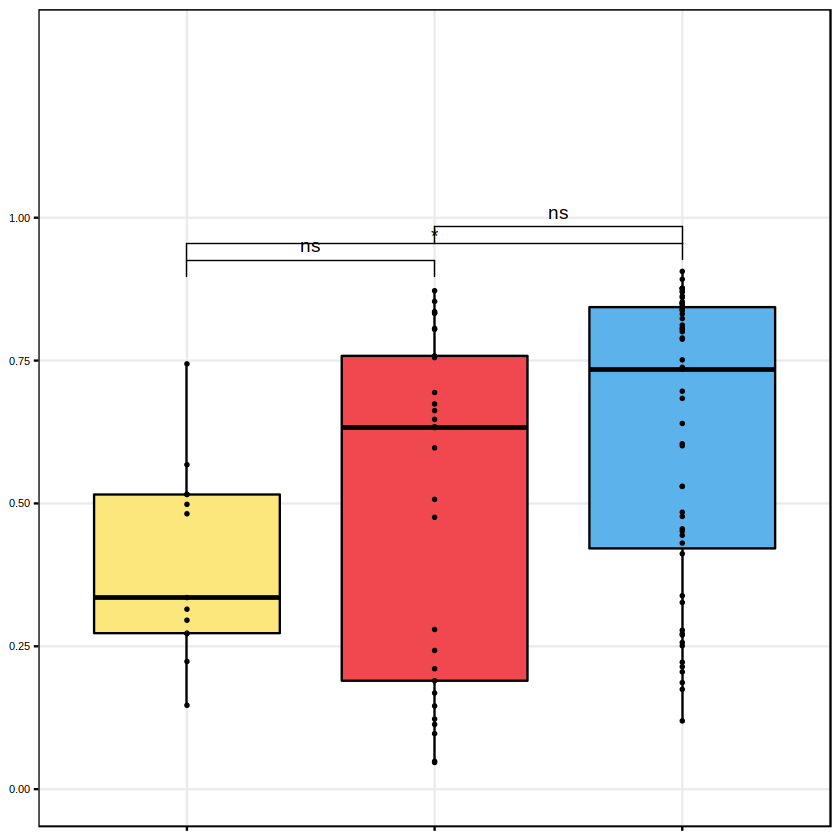

In [14]:
bxplt <- com_all %>% 
    filter(Diagnosis != "Control_Inflammatory") %>%
    ggplot(aes(x=Diagnosis, y=simpson_cfrna))+
    ADD_ON2

stat.test <- data.frame(com_all) %>% filter(Diagnosis != "Control_Inflammatory") %>%
        wilcox_test(simpson_cfrna ~ Diagnosis, paired = FALSE)  %>% 
        adjust_pvalue(method = "BH") %>% 
        add_significance("p.adj") %>% 
        add_xy_position(x = "Diagnosis") 

bxplt <- bxplt +  
stat_pvalue_manual(stat.test, label = "p.adj.signif")+ 
coord_cartesian(ylim = c(0,YLIM)) + scale_y_continuous(breaks = seq(0, 1, by = .25))

bxplt


pdf(file=paste0("plots/SupPanelF_cfrna.pdf"),
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

bxplt

dev.off() 


Coordinate system already present. Adding new coordinate system, which will replace the existing one.

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



png 
  2

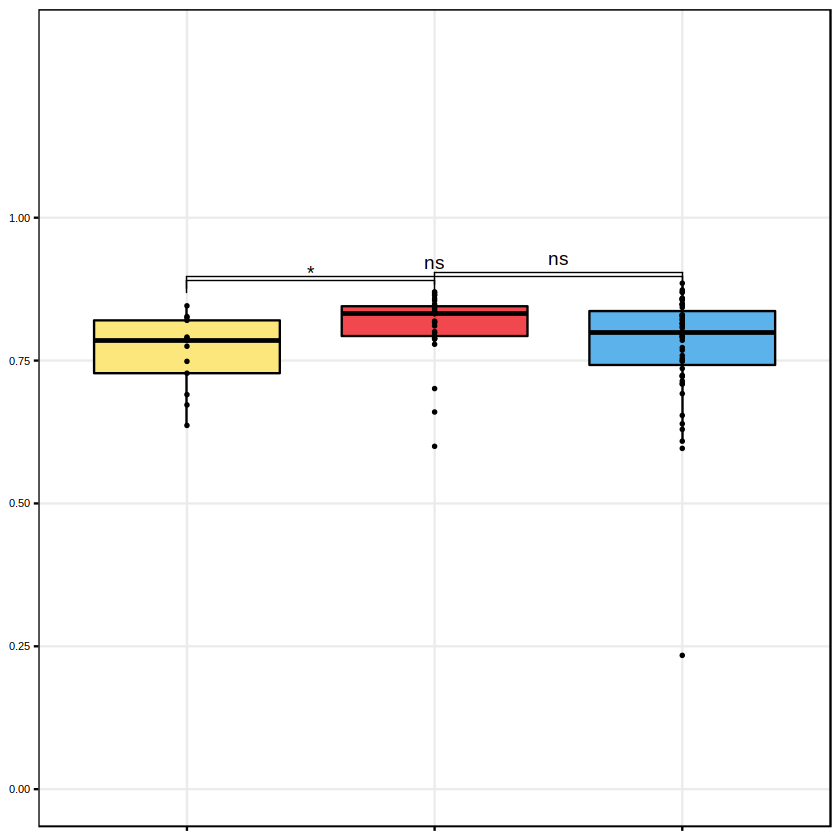

In [15]:
bxplt <- com_all %>% 
    filter(Diagnosis != "Control_Inflammatory") %>%
    ggplot(aes(x=Diagnosis, y=simpson_wbrna))+
    ADD_ON2

stat.test <- data.frame(com_all) %>% filter(Diagnosis != "Control_Inflammatory") %>%
        wilcox_test(simpson_wbrna ~ Diagnosis, paired = FALSE)  %>% 
        adjust_pvalue(method = "BH") %>% 
        add_significance("p.adj") %>% 
        add_xy_position(x = "Diagnosis") 

bxplt <- bxplt +  
stat_pvalue_manual(stat.test, label = "p.adj.signif")+ 
coord_cartesian(ylim = c(0,YLIM)) + scale_y_continuous(breaks = seq(0, 1, by = .25))

bxplt


pdf(file=paste0("plots/SupPanelF_wbrna.pdf"),
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

bxplt

dev.off() 